Lab Report #1: Properties of CCD Cameras

Author: SBU ID# 113827547 

Co-authors: SBU ID# 113181913, SBU ID# 113164004  

In [144]:
import matplotlib.pyplot as plt
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import *
from astropy.visualization import hist
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import warnings
warnings.filterwarnings('ignore')

Question 4.1.1: We open a 0 degrees celsius bias frame and plot a histogram of distribution counts. From this histogram we were able to determine where the hot pixels were and determine what fractions of pixels get rejected after we cut out the hot pixels.

Note: For all color intensity plots (plotting 2-D arrays), we use $\mu \pm 3 \sigma$ to show around $99.6 \%$ of the intensity data and to remove any rare extreme outliers in intensity values.

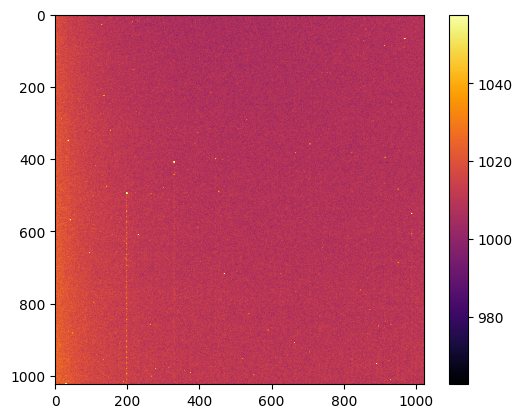

In [95]:
#Plot image
bias_image = CCDData.read('bias_frame.00000000.BIAS.FIT', unit='adu')
plt.imshow(bias_image.data, cmap='inferno', vmin=np.mean(bias_image.data) - 3*np.std(bias_image.data), vmax=np.mean(bias_image.data) + 3*np.std(bias_image.data))
plt.colorbar()

[]

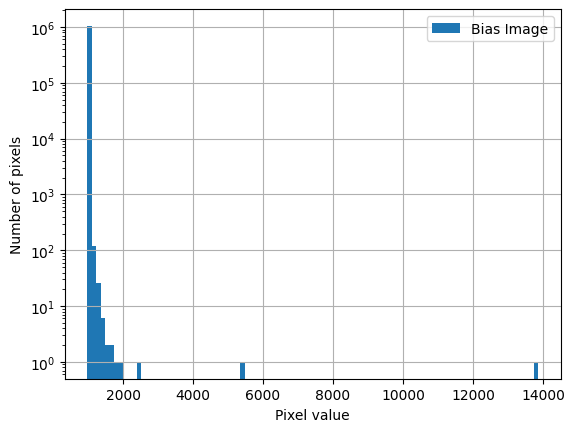

In [96]:
#Plot Histogram
data = bias_image.data.flatten()
hist(data, bins=100, label='Bias Image')
plt.grid()
plt.legend()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.semilogy() #y-axis in log-scale

We can see above that the hot pixels are present in the histogram above at pixel values that are isolated from the main collection of pixel values with only 1 pixel count being registered. We want to remove these hot pixels to create a more uniform and consistent bias image (treated as a dark image with 0 second exposure) to give use a more accurate read noise value.

[]

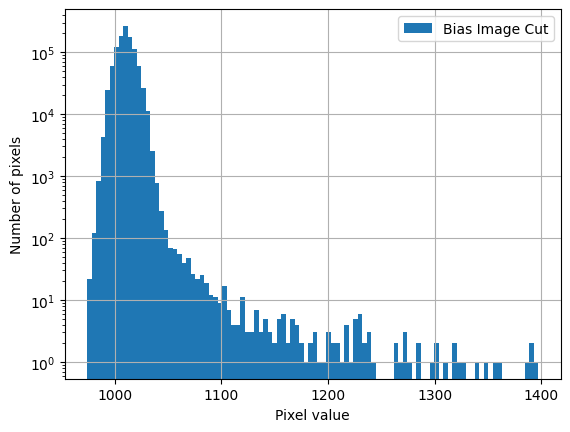

In [97]:
#Plot Cut Histogram 
data_cut = data[data<1400]
hist(data_cut, bins=100, label='Bias Image Cut')
plt.grid()
plt.legend()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.semilogy()

In [143]:
#Fraction of Pixels that get rejected
count = 0
for i in range(len(data)):
    if bias_image.data.flatten()[i] > 1400:
        count = count + 1
print(f"The number of pixels that get rejected is {count}")
print(f"The fraction of pixels that got rejected is {count / len(data)}")

The number of pixels that get rejected is 10
The fraction of pixels that got rejected is 9.5367431640625e-06


Question 4.1.2: The histogram above is a rough Poisson Distribution, however with large mean counts we see that the Poisson Distribution can be approximated to a Gaussian Distribution. We determine the mean and standard deviation from the cut values and then use those values to plot a Gaussian curve on top the histogram. Finally, we get the gain of the CCD camera from the header.

In [99]:
#Calculate the standard deviation and mean for Gaussian Curve
std = np.std(data_cut)
print(f'standard deviation is {std}')
mean = np.mean(data_cut)
print(f'mean is {mean}')
uncert = std/(1024)
print(f'uncertainity is: {uncert}')

standard deviation is 8.329084911741841
mean is 1010.1360992059632
uncertainity is: 0.008133871984122892


In [100]:
#Define the Gaussian Function
def g(sigma,u,x):
    return 1/(sigma*(np.sqrt(2*np.pi))) * np.exp(-(x - u)**2 / (2*sigma**2))

Text(0, 0.5, 'Number of pixels')

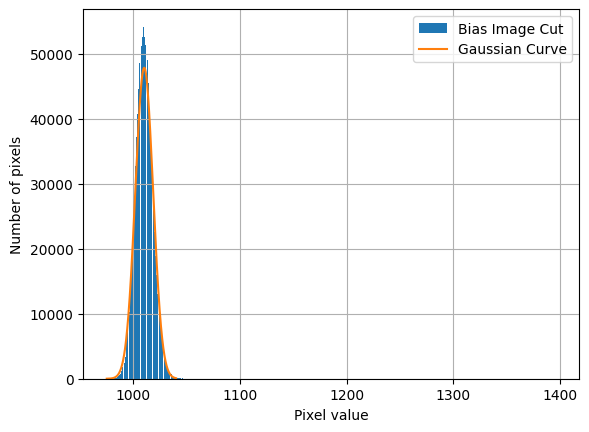

In [101]:
#Plot Cut Histogram with Gaussian Fit
x = np.linspace(975,1040,1040)
hist(data_cut, bins=500, label='Bias Image Cut')
plt.plot(x, 10**6*g(std,mean,x), label='Gaussian Curve')
plt.grid()
plt.legend()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')

In [102]:
#Get Gain information from header
header_image = dict(fits.open('bias_frame.00000000.BIAS.FIT')[0].header)
gain = header_image.get('EGAIN')
print(f"Gain: {gain}")

Gain: 2.06


Read noise is a type of uncertainty that is due to the CCD's electronics. As each pixel value is being read, a small amount of electrons are gained or lost due to quantum processes. This leads to the readout value to vary a little from the actual captured signal. We can calculate the read noise by using the following formula:
$$\text{read noise} = \frac{\sigma \times \text{gain}}{\sqrt{2}}$$

In [103]:
#Bias method for read noise
bias_data_cut = data_cut
read_noise = np.std(bias_data_cut) * gain/ np.sqrt(2)
print(f"Read noise in units of electrons: {read_noise}")

Read noise in units of electrons: 12.132477989672697


Question 4.1 - Data Summary:
$\newline$
The bias image is essentially a dark frame with 0 second exposure and is needed to determine the read noise present in our images. We used a histogram visualization to determine where hot pixels existed and cut them out, creating a more uniform bias image that can more help us determine a read noise value more accurately. The bias image data is a Poisson distribution of photon counts, however statistically Poisson distributions with high mean values can be estimated as a Gaussian distribution. Using the mean and standard deviation calculated (1010.136 and 8.329, respectively), we can formulate a Gaussian estimation that is represented by the function:
$$P(x) = \frac{1}{8.329 \sqrt{2 \pi}} e^{\frac{-(x - 1010.136)^2}{138.744}}$$
Finally, using the read noise formula stated in the cell about we get a result of 12.132 e- RMS compared to the manufacturer's value of 14.8 e- RMS.

Question 4.2.1: We make a median combine of the series of 10 dark frames that all have the same 30 second exposure time. Combining these files create the $master\, dark\, frame$. We then make a histogram to determine where hot pixels are present and where they should be removed from.

In [104]:
#Combining 10 dark images with 30s exposure time and finding median
ccd1 = CCDData.read('dark_frame_30s.06.DARK.FIT', unit='adu')
ccd2 = CCDData.read('dark_frame_30s.07.DARK.FIT', unit='adu')
ccd3 = CCDData.read('dark_frame_30s.08.DARK.FIT', unit='adu')
ccd4 = CCDData.read('dark_frame_30s.09.DARK.FIT', unit='adu')
ccd5 = CCDData.read('dark_frame_30s.10.DARK.FIT', unit='adu')
ccd6 = CCDData.read('dark_frame_30s.11.DARK.FIT', unit='adu')
ccd7 = CCDData.read('dark_frame_30s.12.DARK.FIT', unit='adu')
ccd8 = CCDData.read('dark_frame_30s.13.DARK.FIT', unit='adu')
ccd9 = CCDData.read('dark_frame_30s.14.DARK.FIT', unit='adu')
ccd10 = CCDData.read('dark_frame_30s.15.DARK.FIT', unit='adu')

combiner = Combiner([ccd1, ccd2, ccd3, ccd4, ccd5, ccd6, ccd7, ccd8, ccd9, ccd10])
combined_median = np.array(combiner.median_combine())

In [105]:
#Making new FIT file from median array
hdu = fits.PrimaryHDU(combined_median)
hdul = fits.HDUList([hdu])
hdu.writeto('master_dark_frame_30s.DARK.FIT', overwrite=True)

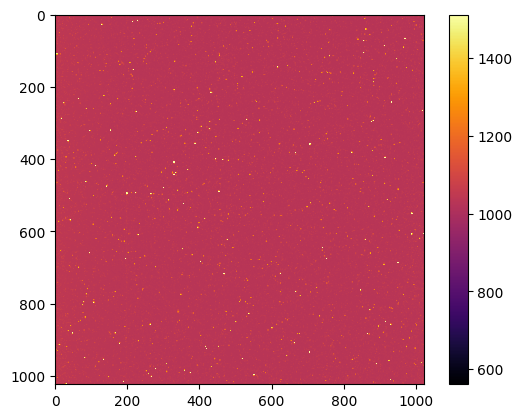

In [106]:
#Master Dark Frame
dark_image = CCDData.read('master_dark_frame_30s.DARK.FIT', unit='adu')
plt.imshow(dark_image.data, cmap='inferno', vmin = np.mean(dark_image.data) - 3*(np.std(dark_image.data)), vmax= np.mean(dark_image.data) + 3*(np.std(dark_image.data)))
plt.colorbar()

[]

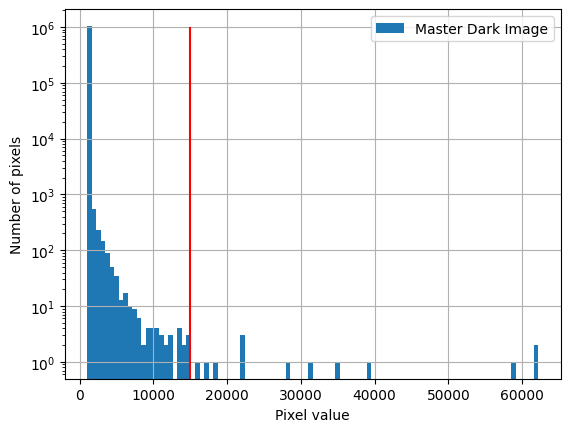

In [107]:
#Plot Master Dark Image Histogram
dark0 = dark_image.data.flatten()
hist(dark0, bins=100, label='Master Dark Image')
plt.grid()
plt.vlines(15000,0,1e6, colors='red') #used to figure out at which point hot pixels should be cut out
plt.legend()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.semilogy() #y-axis in log-scale

[]

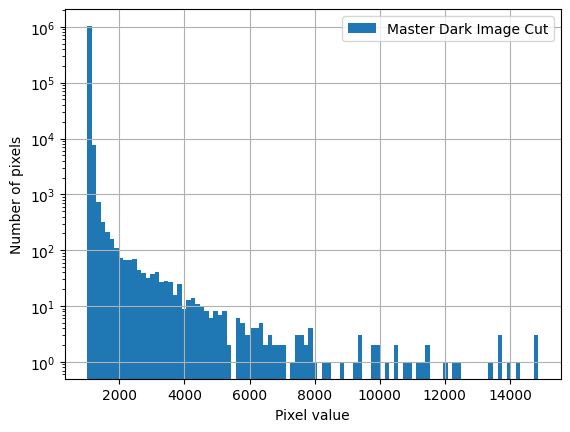

In [108]:
#Plot Cut Histogram
dark_cut0 = dark0[dark0<15000]
hist(dark_cut0, bins=100, label='Master Dark Image Cut')
plt.grid()
plt.legend()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.semilogy() #y-axis in log-scale

Question 4.2.2: For each dark frame from 10 seconds exposure to 120 seconds exposure we find the mean, standard deviation, and statistical uncertainty of the mean counts. However, we find these statistics on the cut data for each dark frame. We also consider the bias image as that would essentially be a dark frame with an exposure of 0 seconds.

In [109]:
ccd11 = CCDData.read('dark_frame_10s.05.DARK.FIT', unit='adu')
dark_10s = ccd11.data.flatten()
dark_10s_cut = dark_10s[dark_10s < 15000]
dark_30s = ccd10.data.flatten()
dark_30s_cut = dark_30s[dark_30s < 15000]
ccd12 = CCDData.read('dark_frame_60s.16.DARK.FIT', unit='adu')
dark_60s = ccd12.data.flatten()
dark_60s_cut = dark_60s[dark_60s < 15000]
ccd13 = CCDData.read('dark_frame_90s.17.DARK.FIT', unit='adu')
dark_90s = ccd13.data.flatten()
dark_90s_cut = dark_90s[dark_90s < 15000]
ccd14 = CCDData.read('dark_frame_120s.18.DARK.FIT', unit='adu')
dark_120s = ccd14.data.flatten()
dark_120s_cut = dark_120s[dark_120s < 15000]
darks_array = ([bias_data_cut, dark_10s_cut, dark_30s_cut, dark_60s_cut, dark_90s_cut,dark_120s_cut])

In [110]:
mean_counts = np.array([])
standard_deviations = np.array([])
uncertainties = np.array([])
exp_time = np.array([0, 10, 30, 60, 90, 120])

for i in range(len(darks_array)):
    mean_counts = np.append(mean_counts, np.mean(darks_array[i]))
for j in range(len(darks_array)):
    standard_deviations = np.append(standard_deviations, np.std(darks_array[j]))
for k in range(len(standard_deviations)):
    uncertainties = np.append(uncertainties, standard_deviations[k]/1024)

We also are interested in estimating the systematic uncertainities with our data. This type of uncertainity doesn't improve with repeated measurements as it is an error usually related to instrumentation rather than random sampling. We can estimate the systematic uncertainty within a 68% confidence interval by changing the range of count values used to compute the mean.

[]

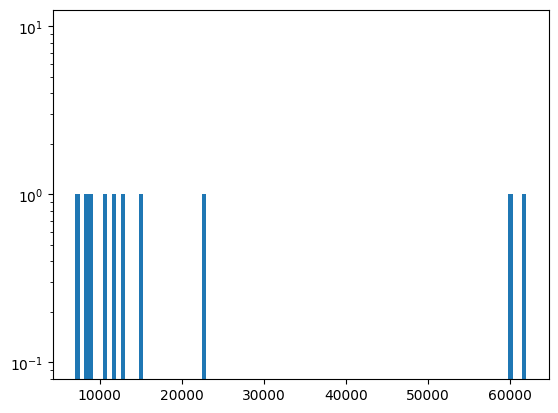

In [111]:
#Plot Histogram of Dark Frame and change the cut
plt.hist(dark_10s[dark_10s > 7000], bins=100)
plt.semilogy()

We can see that the main type of uncertainty that dominates is the systematic uncertainty. This is because as we change the cut, we can see that on the histogram the hot pixels start to dominate. Hot pixels cannot be easily subtracted from an image via dark frame subtraction and will ALWAYS be present in any CCD image. There are ways to mask out hot pixels, however at the end they will still preside as an inevitable source of error.

The equation for the linear regression is: 0.890586977710142*x + 1008.9926248820497


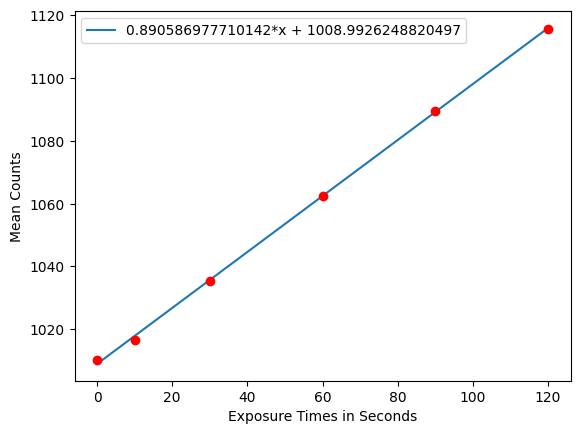

In [112]:
#Make a scatter plot of the mean counts against exposure time and fit a linear regression
plt.errorbar(exp_time, mean_counts, yerr= uncertainties, fmt='o', color='red')
m, b = np.polyfit(exp_time, mean_counts, deg = 1)
x_values = np.linspace(0,120, 6)
plt.plot(x_values, m*x_values + b, label='0.890586977710142*x + 1008.9926248820497') #error bars were calculated however are too small to show up on plot 
plt.xlabel('Exposure Times in Seconds')
plt.ylabel('Mean Counts')
plt.legend()
print(f'The equation for the linear regression is: {m}*x + {b}')

Text(0, 0.5, 'Residual from Linear Regression Model')

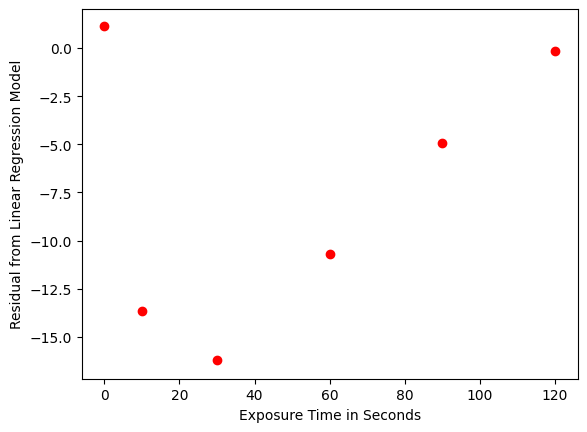

In [113]:
#Plotting a residual plot to determine if the linear regression is a good description of the data
def residual(m,b, x_values):
    return mean_counts - (m*x_values+b)

plt.errorbar(exp_time, residual(m,b,x_values), yerr= uncertainties, fmt='o', color='red') #error bars were calculated however are too small to show up on plot
plt.xlabel('Exposure Time in Seconds')
plt.ylabel('Residual from Linear Regression Model')

Based on this residual plot, we can see that the linear regression is a good description of the data as the residual data points are somewhat randomly distributed.

We then calculate the dark current by using the formula:
$$\text{dark current}= \text{gain} \times \frac{\text{mean counts}}{\text{exposure time}}$$

In [114]:
#Dark Current 
dark_current = gain * m
print(f"The manufacturer's dark current is listed as 9 e-/p/s, while our calculated dark current is {dark_current} e-/p/s ")

The manufacturer's dark current is listed as 9 e-/p/s, while our calculated dark current is 1.8346091740828925 e-/p/s 


We then repeat this process for the dark frame at 10 degrees Celsius.

[]

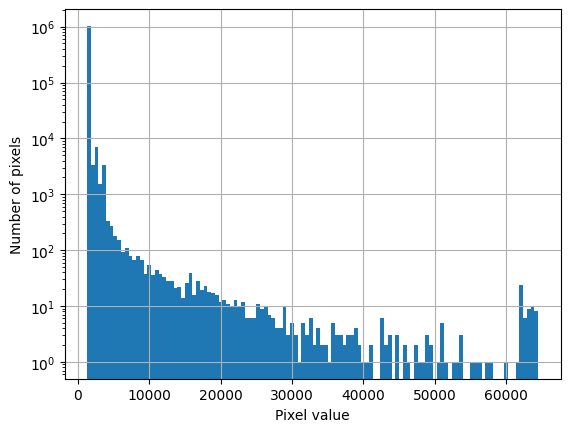

In [115]:
ccd_dark10 = CCDData.read('dark_frame_tenC.20.DARK.FIT', unit='adu')
header_dark10 = dict(fits.open('dark_frame_tenC.20.DARK.FIT')[0].header)
exp_dark10 = header_dark10.get('EXPTIME') #Find the exposure time of the 10 degrees celsius dark frame

dark_10 = ccd_dark10.data.flatten()
plt.hist(dark_10, bins=120)
plt.grid()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.semilogy()

In [116]:
#We now cut down the data to remove the hot pixels
dark_10_cut = dark_10[dark_10 < 40000]
print(f"the dark current for the 10 degrees celsius dark frame is: {gain*(np.mean(dark_10_cut)/exp_dark10)} e-/p/s")
mean_dark10 = np.mean(dark_10_cut)

the dark current for the 10 degrees celsius dark frame is: 25.760170620046356 e-/p/s


The dark current for the 10 degrees celsius dark increased compared to the 0 degree celsius dark frame. This is expected since dark current is due to the thermal excitation of electrons in the CCD. As temperature increases so does vibrations of the electrons making the dark current increase.

Question 4.2 - Data Summary:
$\newline$
Dark Frames are images that are taken at a specific exposure time and temperature with a closed shutter, resulting in no photon counts being registered by the CCD camera. This lets us figure out the dark current of the CCD. Dark Current is the result of the quantum behaviour that electrons exhibit where they can tunnel into the conduction band. This results in a signal, even if there were no photons physically hitting the CCD. We were able to calculate the dark current by plotting the mean counts of all our 0 celsius dark frames against their respective exposure times. Using the slope of the linear regression line, we then multiplied by the gain to get a final result of 1.835 e-/p/s. This is within the same order of magnitude reported by the manufacturer's value of 9 e-/p/s. The difference between our calculated value and the manufacturer's value may be a result from years of physical wear and tear on the CCD camera itself. We repeated this same process with our 10 degrees celsius dark frame and calculated a dark current of 25.760 e-/p/s. This is expected since dark current is due to the thermal excitation of electrons in the CCD. As temperature increases so does vibrations of the electrons making the dark current increase.

Question 4.3.1: We take the median of the 10 flat-fields to reduce noise from photon-counting. We then normalize the combined median to create the master flat-field.

In [117]:
#Flat-field Images
flat1 = CCDData.read('flat_fields_frame.00000005.FIT', unit='adu')
flat2 = CCDData.read('flat_fields_frame.00000006.FIT', unit='adu')
flat3 = CCDData.read('flat_fields_frame.00000007.FIT', unit='adu')
flat4 = CCDData.read('flat_fields_frame.00000008.FIT', unit='adu')
flat5 = CCDData.read('flat_fields_frame.00000009.FIT', unit='adu')
flat6 = CCDData.read('flat_fields_frame.00000010.FIT', unit='adu')
flat7 = CCDData.read('flat_fields_frame.00000011.FIT', unit='adu')
flat8 = CCDData.read('flat_fields_frame.00000012.FIT', unit='adu')
flat9 = CCDData.read('flat_fields_frame.00000013.FIT', unit='adu')
flat10 = CCDData.read('flat_fields_frame.00000014.FIT', unit='adu')

combiner_flats = Combiner([flat1, flat2, flat3, flat4, flat5, flat6, flat7, flat8, flat9, flat10])
combined_median_flats = np.array(combiner_flats.median_combine())
mean_flats = np.mean(combined_median_flats)
normed = combined_median_flats/mean_flats

In [118]:
hdu_flats = fits.PrimaryHDU(normed)
hdul_flats = fits.HDUList([hdu_flats])
hdu_flats.writeto('normed_master_flat.FIT', overwrite='True')

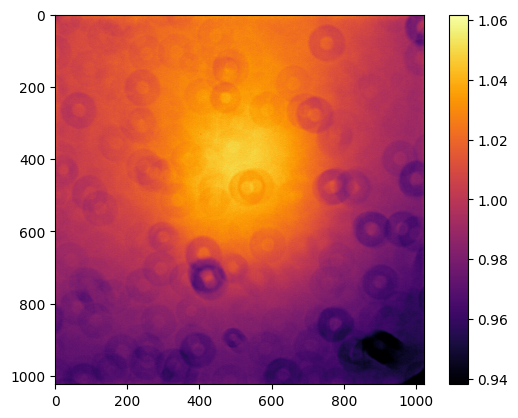

In [119]:
#Master Flat Field
flat_image = CCDData.read('normed_master_flat.FIT', unit='adu')
plt.imshow(flat_image.data, cmap ='inferno', vmin= np.mean(flat_image.data) - 2.5*(np.std(flat_image.data)), vmax = np.mean(flat_image.data) + 2.5*(np.std(flat_image.data)))
plt.colorbar()

Question 4.3.2: Using Ds9 we can see that the intensity of the dimmest part of the master flat-field is 0.922219, while the brightest part is 1.04341. Thus, the fraction of light would be
$$\frac{0.922219}{1.04341} = 0.88385$$

Question 4.3.3: The observed magnitude would change by the fraction of light we calculated in the cell above. Therefore the star close to the corner would be 0.88385 times brighter than the star in the center of the image.

Question 4.3.4: We now plot a histogram of the counts in our master flat-field to determine if there are any dead pixels. A dead pixel would be if there are no registered counts being shown (pixel value is 0).

Text(0, 0.5, 'Number of pixels')

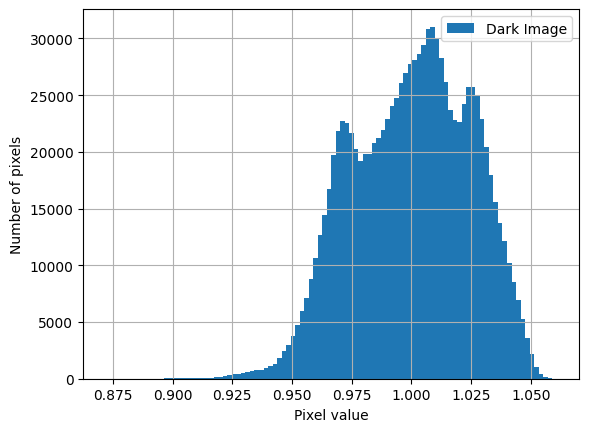

In [120]:
hist(flat_image.data.flatten(), bins=100, label='Dark Image')
plt.grid()
plt.legend()
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')

From the histogram, no dead pixels can be observed. This because there no pixels that have been registered to have a pixel value of 0.

Question 4.3.5: No you cannot take your flat-field images the next day. While in theory flat-field images are acquired by imaging a uniformily lit environment (like a dark night sky), the actual uniformity may change day-to-day and result in differeing flat field images. If you take a dome flat-field the light is theoretically more stable and consistent, but it can still differ because of background lights from the sky or cosmic rays.

Question 4.3 - Data Summary:
$\newline$
We created a master flat-field image by taking the median of the images and then normalizing the median image by the mean of the array. 
A master flat field was created from the combination of all the flat field images along with normalizing,
which means calculating the mean and dividing the combination of flat fields by the mean. The final
normalization of the masterflat is needed to stabilize any extremities in brightness fluctuations and results in a data array with values varying from 0 to 1. Flat fields are used to measure the brightness sensitivity throughout the CCD and thus are needed to calibrate our Saturn images.


Question 4.4.2: We choose the 25 $\mu m$ slit and then collapse the flat-field matrix (2-D array) to a vector (1-D array) by taking the median of each column. From this new "vectorized" array we can plot it against the x-positions of the dispersion axis.

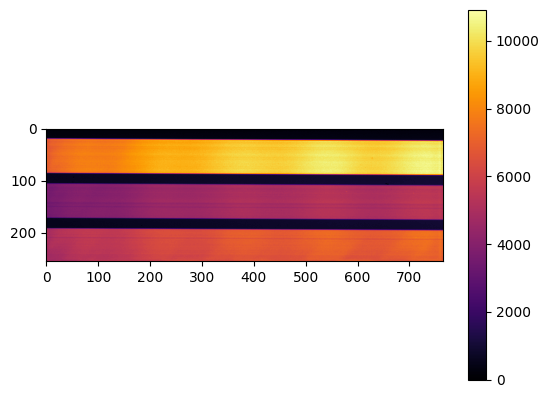

In [121]:
#Uncut arc lamp flat field data
flat_spectro = CCDData.read('flat_fields.00000007.FIT', unit='adu')
plt.imshow(flat_spectro.data, cmap='inferno')
plt.colorbar()

In [122]:
#Cut the data to only have the data for the 25 micrometer slit
flat_spectro_cut = flat_spectro.data[106:176,:]
hdu_spec = fits.PrimaryHDU(flat_spectro_cut)
hdul_spec = fits.HDUList([hdu_spec])
hdu_spec.writeto('cut_spec.FIT', overwrite=True)

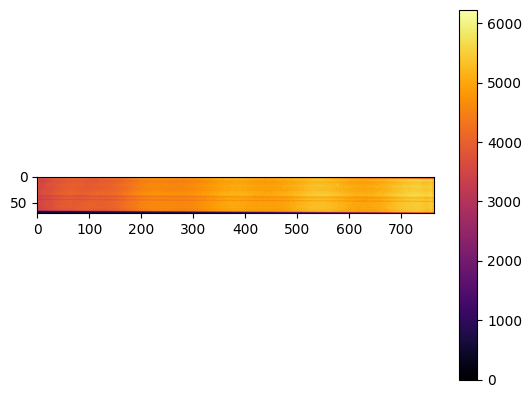

In [123]:
spec_image = CCDData.read('cut_spec.FIT', unit='adu')
plt.imshow(spec_image.data, cmap='inferno')
plt.colorbar()

Text(0, 0.5, 'Flat-Field Values')

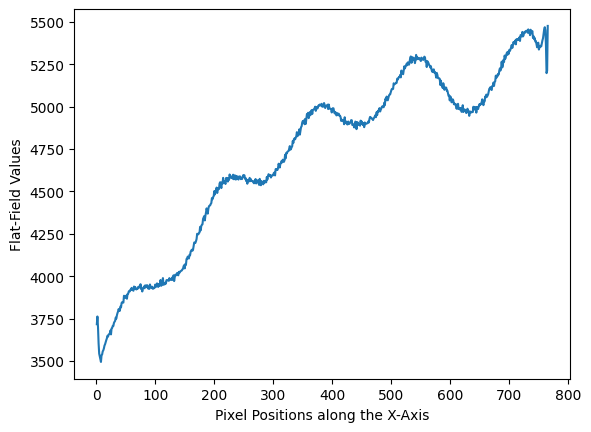

In [124]:
#Flatten the spectrum data and plot the flat-field values against the pixel positions
median_spec_image = np.median(spec_image.data, axis=0)
x_pos = np.linspace(1,765,765)
plt.plot(x_pos, median_spec_image)
plt.xlabel('Pixel Positions along the X-Axis')
plt.ylabel('Flat-Field Values')

Question 4.4.3: Variations in the flat-field counts with wavelength may occur when a change in brightness sensitiity arises either due to the surroundings or the intrinsic spectrum of the arc lamp. As such, it is necessary to normalize the flat-field along the dispersion axis to make sure we have values that vary around 1. We normalize the flat-field by fitting a 2nd-order polynomial to the "vectorized" array. We then divide the matrix (2-D array) by this 2nd-order polynomial fit.

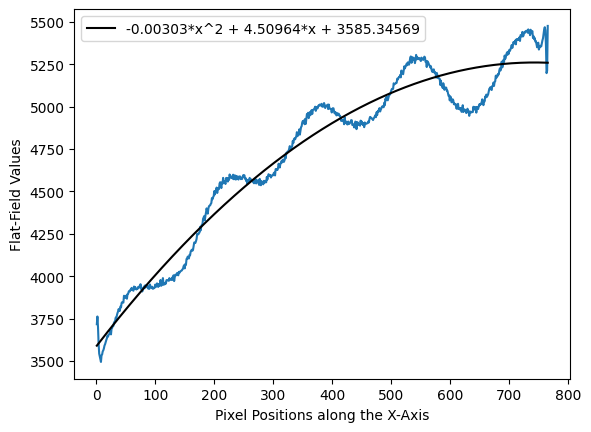

In [125]:
a, b, c = np.polyfit(x_pos, median_spec_image, deg=2)
xseq = np.linspace(1, 765, 765)
plt.plot(x_pos,median_spec_image)
plt.plot(x_pos, a * xseq **2 + b*xseq + c, color="black", lw=1.5, label=f'{np.around(a, 5)}*x^2 + {np.around(b,5)}*x + {np.around(c,5)}')
plt.xlabel('Pixel Positions along the X-Axis')
plt.ylabel('Flat-Field Values')
plt.legend()

In [126]:
#Normalized Flat-Field
normed_flat = spec_image.data/(a * xseq **2 + b*xseq + c)
hdu_norm = fits.PrimaryHDU(normed_flat)
hdul_norm = fits.HDUList([hdu_norm])
hdu_norm.writeto('normed_cut_spec.FIT', overwrite=True)

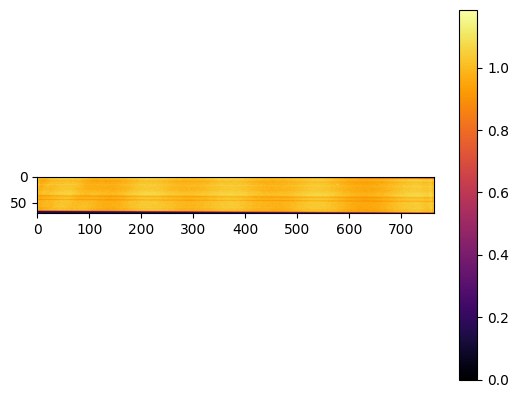

In [127]:
normed_flat_image = CCDData.read('normed_cut_spec.FIT', unit='adu')
plt.imshow(normed_flat_image.data, cmap='inferno')
plt.colorbar()

Flat field frames are used to correct for brightness variations in the CCD, and sensitivity variances between pixels in the CCD. A flat field frame is basically an image of a uniformly-lit field. Printing the array values of the original and normed flat-fields we see that the normed flat-field has values that vary around 1.  Since the flat captures detector variations, the normed flat is useful as when divided into an image, it would help balance out intesity variations.

Question 4.4.4: We cut the actual arc lamp spectrum to show only the data for the $25 \mu m$ slit. We then normalize the specturm using the 2nd-order polynomial fit from the previous section.

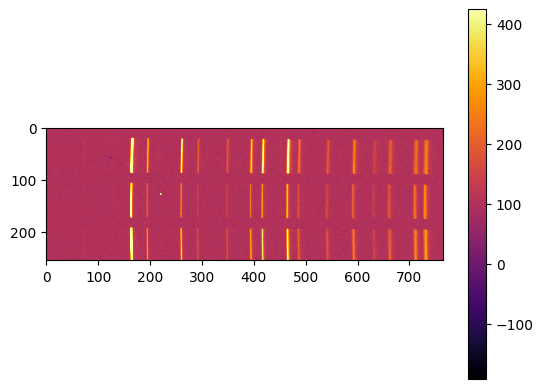

In [128]:
#Uncut Arc Lamp Spectrum
arclamp_spec = CCDData.read('arc_lamp_spectrum.00000002.FIT', unit='adu')
plt.imshow(arclamp_spec.data, cmap='inferno', vmin=np.mean(arclamp_spec.data) - 3*np.std(arclamp_spec.data), vmax = np.mean(arclamp_spec.data) + 3*np.std(arclamp_spec.data))
plt.colorbar()

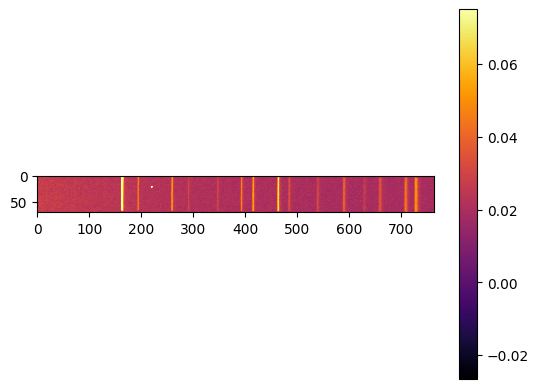

In [129]:
#Cutting the arc lamp specturm for the 25 micrometer slit
arclamp_spec_cut = arclamp_spec.data[106:176, :]
normed_spec = arclamp_spec_cut/(a * xseq **2 + b*xseq + c)
plt.imshow(normed_spec, cmap='inferno', vmin= np.mean(normed_spec) - 3*(np.std(normed_spec)), vmax= np.mean(normed_spec) + 3*(np.std(normed_spec)))
plt.colorbar()

Question 4.4.5: 
Here the wavelength from the arc lamp spectrum must be calibrated. In order to do this we open the image in ds9 and record the pixel value for each emission line in the normed arc lamp spectrum. Then, we find the wavelength values for neon's emission lines. After that we create an array of these two data sets and make a plot of the wavelength versus pixel position with a linear regression.

In [130]:
# creating an array of the pixel values for each emission line in the normed arc lamp spectrum 
# values taken from Ds9
pixel_value_spec = np.array([164.829, 195.5, 260.894, 292.722, 348.856, 417.144, 465.755, 486, 588, 541.565, 
                             593.648, 630.685, 662.514, 711.125, 732.537])

# creating an array of an example wavelength for neon's emission lines (wavelength in nm)
# values taken from google
ex_wavelength = np.array([540.1, 585.2, 588.2, 603.0, 607.4, 616.4, 621.7, 626.6, 633.4, 638.3, 640.2, 650.6, 
                          659.9, 692.9, 703.2])

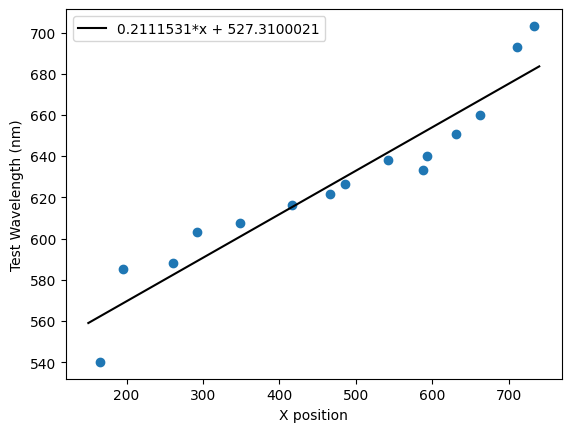

In [131]:
plt.scatter(pixel_value_spec, ex_wavelength)
b, a = np.polyfit(pixel_value_spec, ex_wavelength, deg=1)
xseq = np.linspace(150, 740, 15)
plt.plot(xseq, a + b * xseq, color="k", lw=1.5, label=f"{np.round(b,7)}*x + {np.round(a,7)}")
plt.xlabel('X position')
plt.ylabel('Test Wavelength (nm)')
plt.legend()

The wavelength calibration function is:
$$\lambda = 0.2111531 x_{pos} + 527.31$$

Text(0, 0.5, 'Residuals from Linear Regression')

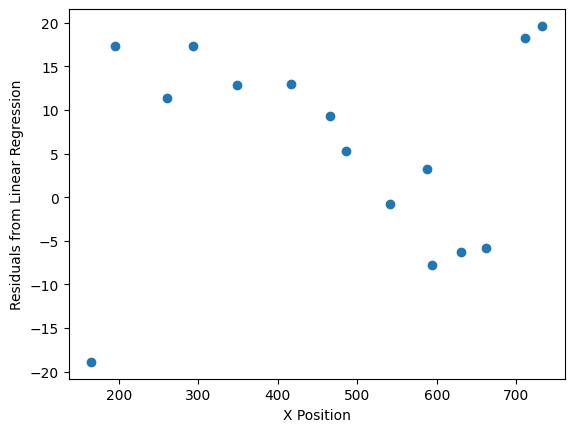

In [132]:
def w_residual(a,b, xseq):
    return ex_wavelength - (a + b * xseq)

plt.scatter(pixel_value_spec, w_residual(a,b, xseq))
plt.xlabel('X Position')
plt.ylabel('Residuals from Linear Regression')

Question 4.4.6: We plot the calibrated spectrum, with Neon emission lines labelled on the plot.

Text(0, 0.5, 'Intensity')

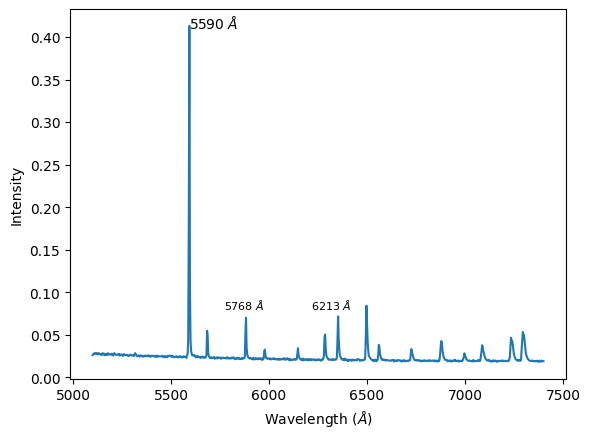

In [133]:
intesnity_counts = np.median(normed_spec.data, axis = 0) # Intensity counts
xseq2 = np.linspace(510*10, 740*10, 765) # the range of the wavelength data converted to Angstroms
wavelength = np.array(a + b * xseq2) # array of the calibrated wavelengths

plt.plot(xseq2, intesnity_counts)
plt.text(5590, 0.41, r'5590 $\AA$', fontsize = 10)
plt.text(5768, 0.08, r'5768 $\AA$', fontsize = 8)
plt.text(6213, 0.08, r'6213 $\AA$', fontsize = 8)
plt.xlabel(r'Wavelength ($\AA$)')
plt.ylabel('Intensity')

Question 4.4.7: 
The length of the spectrum that is covered by the spectrograph is 6835.6 angstroms and the dispersion is from 0-765.

Question 4.4 - Data Summary:
$\newline$
We created a normalized arc lamp flat field image by taking the original flat field and "vectorizing" it into a 1-D array. Then, we plotted the flat field data against the x-positions of the arc lamp spectra and fitted a 2nd-order polynomial. We divided the original flat field by this polynomial fit to create the normed flat-field. We also used the polynomial fit to create a normalized arc lamp spectrum, from which we derived the wavelength calibration.

Question 4.5:
To calibrate the images what we would do is subtract the master dark image for the 10s exposure from the saturn filter that had 10 second exposure, then we would divide that by the master normed flat field. For the red and visible which were both 100s exposure we would subtract the master dark for the 100s exposure and then divide by master flat field. We could take the bias and darks a different day, but not the flat fields.

Question 4.6: We took an image of Saturn in red, blue and green filters. To compose a full image, we needed to calibrate each filter by subtracted the respective dark frames and dividing by the normalized flat fields. Then, we created an empty array to transfer the red, green and blue data into a large 1024 by 1024 by 3 array. Finally, we shifted the coordinates of the read, green and blue array so they would overlap and stack to compose a full image.

In [134]:
#Blue flat-fields
blue_flat1 = CCDData.read('flat_fields_frame_blue.00000015.FIT', unit='adu')
blue_flat2 = CCDData.read('flat_fields_frame_blue.00000016.FIT', unit='adu')
blue_flat3 = CCDData.read('flat_fields_frame_blue.00000017.FIT', unit='adu')
blue_flat4 = CCDData.read('flat_fields_frame_blue.00000018.FIT', unit='adu')
blue_flat5 = CCDData.read('flat_fields_frame_blue.00000019.FIT', unit='adu')
blue_flat6 = CCDData.read('flat_fields_frame_blue.00000020.FIT', unit='adu')
blue_flat7 = CCDData.read('flat_fields_frame_blue.00000021.FIT', unit='adu')
blue_flat8 = CCDData.read('flat_fields_frame_blue.00000022.FIT', unit='adu')
blue_flat9 = CCDData.read('flat_fields_frame_blue.00000023.FIT', unit='adu')
blue_flat10 = CCDData.read('flat_fields_frame_blue.00000024.FIT', unit='adu')
blue_flat11 = CCDData.read('flat_fields_frame_blue.00000025.FIT', unit='adu')
blue_flat12 = CCDData.read('flat_fields_frame_blue.00000026.FIT', unit='adu')

# taking the median combine of the blue flats and norming
combiner_blue_flats = Combiner([blue_flat1, blue_flat2, blue_flat3, blue_flat4, blue_flat5, blue_flat6, blue_flat7, blue_flat8, blue_flat9, blue_flat10, blue_flat11, blue_flat12])
combined_blue_median_flats = np.array(combiner_blue_flats.median_combine())
mean_blue_flats = np.mean(combined_blue_median_flats)
normed_blue_flats = combined_blue_median_flats/mean_blue_flats

In [135]:
#Combining dark images for the blue filter
saturn_bdark1 = CCDData.read('saturn_blue_darks.00000040.DARK.FIT', unit='adu')
saturn_bdark2 = CCDData.read('saturn_blue_darks.00000041.DARK.FIT', unit='adu')
saturn_bdark3 = CCDData.read('saturn_blue_darks.00000042.DARK.FIT', unit='adu')
saturn_bdark4 = CCDData.read('saturn_blue_darks.00000043.DARK.FIT', unit='adu')
saturn_bdark5 = CCDData.read('saturn_blue_darks.00000044.DARK.FIT', unit='adu')
saturn_bdark6 = CCDData.read('saturn_blue_darks.00000045.DARK.FIT', unit='adu')
saturn_bdark7 = CCDData.read('saturn_blue_darks.00000046.DARK.FIT', unit='adu')
saturn_bdark8 = CCDData.read('saturn_blue_darks.00000047.DARK.FIT', unit='adu')
saturn_bdark9 = CCDData.read('saturn_blue_darks.00000048.DARK.FIT', unit='adu')
saturn_bdark10 = CCDData.read('saturn_blue_darks.00000049.DARK.FIT', unit='adu')

combiner2 = Combiner([saturn_bdark1, saturn_bdark2, saturn_bdark3, saturn_bdark4, saturn_bdark5, saturn_bdark6, saturn_bdark7,
                     saturn_bdark8, saturn_bdark9, saturn_bdark10])
combined_blue_darks = np.array(combiner2.median_combine())

In [136]:
#Combining the blue filter images
saturn_blue1 = CCDData.read('saturn_blue.00000030.FIT', unit='adu')
saturn_blue2 = CCDData.read('saturn_blue.00000031.FIT', unit='adu')
saturn_blue3 = CCDData.read('saturn_blue.00000032.FIT', unit='adu')
saturn_blue4 = CCDData.read('saturn_blue.00000033.FIT', unit='adu')
saturn_blue5 = CCDData.read('saturn_blue.00000034.FIT', unit='adu')
saturn_blue6 = CCDData.read('saturn_blue.00000035.FIT', unit='adu')
saturn_blue7 = CCDData.read('saturn_blue.00000036.FIT', unit='adu')
saturn_blue8 = CCDData.read('saturn_blue.00000037.FIT', unit='adu')
saturn_blue9 = CCDData.read('saturn_blue.00000038.FIT', unit='adu')
saturn_blue10 = CCDData.read('saturn_blue.00000039.FIT', unit='adu')

combiner3 = Combiner([saturn_blue1, saturn_blue2, saturn_blue3, saturn_blue4, saturn_blue5, saturn_blue6, saturn_blue7,
                     saturn_blue8, saturn_blue9, saturn_blue10])
combined_blue = np.array(combiner3.median_combine())

#Calibrated Image
calibrated_blue = (combined_blue - combined_blue_darks)/normed_blue_flats

In [137]:
#Combining Saturn Darks for Green Filter
saturn_vdark1 = CCDData.read('saturn_visible_darks.00000010.DARK.FIT', unit='adu')
saturn_vdark2 = CCDData.read('saturn_visible_darks.00000011.DARK.FIT', unit='adu')
saturn_vdark3 = CCDData.read('saturn_visible_darks.00000012.DARK.FIT', unit='adu')
saturn_vdark4 = CCDData.read('saturn_visible_darks.00000013.DARK.FIT', unit='adu')
saturn_vdark5 = CCDData.read('saturn_visible_darks.00000014.DARK.FIT', unit='adu')
saturn_vdark6 = CCDData.read('saturn_visible_darks.00000015.DARK.FIT', unit='adu')
saturn_vdark7 = CCDData.read('saturn_visible_darks.00000016.DARK.FIT', unit='adu')
saturn_vdark8 = CCDData.read('saturn_visible_darks.00000017.DARK.FIT', unit='adu')
saturn_vdark9 = CCDData.read('saturn_visible_darks.00000018.DARK.FIT', unit='adu')
saturn_vdark10 = CCDData.read('saturn_visible_darks.00000019.DARK.FIT', unit='adu')

combiner4 = Combiner([saturn_vdark1, saturn_vdark2, saturn_vdark3, saturn_vdark4, saturn_vdark5, saturn_vdark6, saturn_vdark7,
                     saturn_vdark8, saturn_vdark9, saturn_vdark10])
combined_green_darks = np.array(combiner4.median_combine())

In [138]:
#Combining Saturn images with Green Filter
saturn_visible1 = CCDData.read('saturn_visible.00000000.FIT', unit='adu')
saturn_visible2 = CCDData.read('saturn_visible.00000001.FIT', unit='adu')
saturn_visible3 = CCDData.read('saturn_visible.00000002.FIT', unit='adu')
saturn_visible4 = CCDData.read('saturn_visible.00000003.FIT', unit='adu')
saturn_visible5 = CCDData.read('saturn_visible.00000004.FIT', unit='adu')
saturn_visible6 = CCDData.read('saturn_visible.00000005.FIT', unit='adu')
saturn_visible7 = CCDData.read('saturn_visible.00000006.FIT', unit='adu')
saturn_visible8 = CCDData.read('saturn_visible.00000007.FIT', unit='adu')
saturn_visible9 = CCDData.read('saturn_visible.00000008.FIT', unit='adu')
saturn_visible10 = CCDData.read('saturn_visible.00000009.FIT', unit='adu')

combiner5 = Combiner([saturn_visible1, saturn_visible2, saturn_visible3, saturn_visible4, saturn_visible5, saturn_visible6, saturn_visible7,
                     saturn_visible8, saturn_visible9, saturn_visible10])
combined_green = np.array(combiner5.median_combine())

#Calibrated Image
calibrated_green = (combined_green - combined_green_darks) / flat_image.data

In [139]:
#Combining the Red Flat-Fields
red_flat1 = CCDData.read('flat_fields_frame_red.00000027.FIT', unit='adu')
red_flat2 = CCDData.read('flat_fields_frame_red.00000028.FIT', unit='adu')
red_flat3 = CCDData.read('flat_fields_frame_red.00000029.FIT', unit='adu')
red_flat4 = CCDData.read('flat_fields_frame_red.00000030.FIT', unit='adu')
red_flat5 = CCDData.read('flat_fields_frame_red.00000031.FIT', unit='adu')
red_flat6 = CCDData.read('flat_fields_frame_red.00000032.FIT', unit='adu')
red_flat7 = CCDData.read('flat_fields_frame_red.00000033.FIT', unit='adu')
red_flat8 = CCDData.read('flat_fields_frame_red.00000034.FIT', unit='adu')
red_flat9 = CCDData.read('flat_fields_frame_red.00000035.FIT', unit='adu')
red_flat10 = CCDData.read('flat_fields_frame_red.00000036.FIT', unit='adu')
red_flat11 = CCDData.read('flat_fields_frame_red.00000037.FIT', unit='adu')
red_flat12 = CCDData.read('flat_fields_frame_red.00000038.FIT', unit='adu')
red_flat13 = CCDData.read('flat_fields_frame_red.00000039.FIT', unit='adu')

# taking the median combine of the red flats and norming
combiner_flats_red = Combiner([red_flat1, red_flat2, red_flat3, red_flat4, red_flat5, red_flat6, red_flat7, red_flat8, red_flat9, 
                               red_flat10, red_flat11, red_flat12, red_flat13])
combined_median_flats_red = np.array(combiner_flats_red.median_combine())
mean_flats_red = np.mean(combined_median_flats_red)
normed_red = combined_median_flats_red/mean_flats_red

In [140]:
#Combining Saturn images with Red filter
saturn_red1 = CCDData.read('saturn_red.00000020.FIT', unit='adu')
saturn_red2 = CCDData.read('saturn_red.00000021.FIT', unit='adu')
saturn_red3 = CCDData.read('saturn_red.00000022.FIT', unit='adu')
saturn_red4 = CCDData.read('saturn_red.00000023.FIT', unit='adu')
saturn_red5 = CCDData.read('saturn_red.00000024.FIT', unit='adu')
saturn_red6 = CCDData.read('saturn_red.00000025.FIT', unit='adu')
saturn_red7 = CCDData.read('saturn_red.00000026.FIT', unit='adu')
saturn_red8 = CCDData.read('saturn_red.00000027.FIT', unit='adu')
saturn_red9 = CCDData.read('saturn_red.00000028.FIT', unit='adu')
saturn_red10 = CCDData.read('saturn_red.00000029.FIT', unit='adu')

combiner6 = Combiner([saturn_red1, saturn_red2, saturn_red3, saturn_red4, saturn_red5, saturn_red6, saturn_red7, 
                      saturn_red8, saturn_red9, saturn_red10])
combined_red = np.array(combiner6.median_combine())

#Calibrated Image
calibrated_red = (combined_red - combined_green_darks)/ normed_red

Stacking and Aligning the Red, Green and Blue Filtered Images of Saturn

In [141]:
calibrated_green = np.roll(calibrated_green, (25, 23), axis = (1,0))
calibrated_blue = np.roll(calibrated_blue, (-30, -28), axis = (1,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(400.0, 700.0)

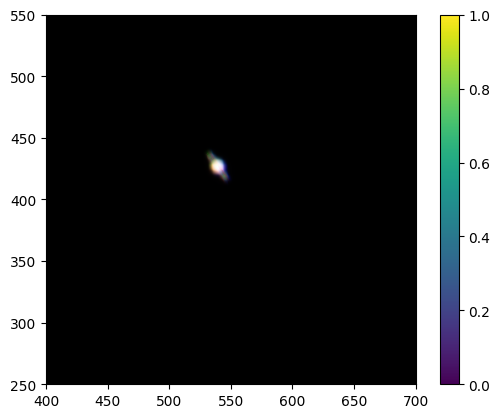

In [142]:
#Final Saturn Image
stacked_test = np.array([calibrated_red/calibrated_red.max(), calibrated_green/calibrated_green.max(), calibrated_blue/calibrated_blue.max()])
stacked = np.zeros((1024,1024,3))
stacked[:,:,0] = stacked_test[0]
stacked[:,:,1] = stacked_test[1]
stacked[:,:,2] = stacked_test[2]

plt.imshow(stacked)
plt.colorbar()
plt.ylim([250,550])
plt.xlim([400,700])

Question 4.6 - Data Summary:
$\newline$
Unfortunately, our stacked images of Saturn did not align on top of one another perfectly. To fix this issue, we could double the resolution by change the shape of each filter array (red, green, blue) to 2048 by 2048. After that, we could interpolate the arrays and create a higher resolution image with far more pixels that would be easier to precisely align. It is also difficult to see Saturn's moon because of the lack of a zscale option, however this can be fixed by importing the file into ds9.
